## Test different training ideas

In [1]:
from fastai.vision import *
from local.semantic_segmentation.datasets import SemanticSegmentationData

In [2]:
PATH = Path("/home/turgutluk/.fastai/data/camvid_tiny/")

In [3]:
# for fname in (PATH/"masks").ls():
#     open_mask(fname).save(fname.parent/f"{fname.stem[:-2]}.png")

In [4]:
defaults.device = torch.device("cuda")

In [5]:
PATH, CODES, TRAIN, VALID, TEST = PATH, "codes.txt", "train.txt", "valid.txt", "test.txt"
segdata = SemanticSegmentationData(PATH, CODES, TRAIN, VALID, TEST, None, bs=64, size=224)

In [6]:
data = segdata.get_data().normalize(imagenet_stats)

In [7]:
data

ImageDataBunch;

Train: LabelList (90 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: /home/turgutluk/.fastai/data/camvid_tiny;

Valid: LabelList (10 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: /home/turgutluk/.fastai/data/camvid_tiny;

Test: LabelList (10 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/turgutluk/.fastai/data/camvid_tiny

### model

In [27]:
learn = unet_learner(data, arch = models.resnet34, pretrained = True)

### loss

In [28]:
from local.semantic_segmentation.losses import *

In [29]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [30]:
# learn.loss_func = lovasz_softmax

### metric

In [31]:
from local.semantic_segmentation.metrics import *

In [32]:
# void_code = np.where(learn.data.classes == "Void")[0].item()
# learn.metrics = [partial(foreground_acc, void_code=void_code)]
learn.metrics = [dice]

### custom scheduling

In [33]:
from local.schedular import fit_with_annealing

### opt_func

In [34]:
from local.optimizers import *

In [35]:
opt = "ranger"

In [36]:
alpha=0.99; mom=0.9; eps=1e-8; lr=3e-3; epochs=5; ann_start=0.2

if   opt=='adam' : opt_func = partial(optim.Adam, betas=(mom,alpha), eps=eps)
elif opt=='radam' : opt_func = partial(RAdam, betas=(mom,alpha), eps=eps)
elif opt=='novograd' : opt_func = partial(Novograd, betas=(mom,alpha), eps=eps)
elif opt=='rms'  : opt_func = partial(optim.RMSprop, alpha=alpha, eps=eps)
elif opt=='sgd'  : opt_func = partial(optim.SGD, momentum=mom)
elif opt=='ranger'  : opt_func = partial(Ranger,  betas=(mom,alpha), eps=eps)
elif opt=='ralamb'  : opt_func = partial(Ralamb,  betas=(mom,alpha), eps=eps)
elif opt=='rangerlars'  : opt_func = partial(RangerLars,  betas=(mom,alpha), eps=eps)
elif opt=='lookahead'  : opt_func = partial(LookaheadAdam, betas=(mom,alpha), eps=eps)
elif opt=='lamb'  : opt_func = partial(Lamb, betas=(mom,alpha), eps=eps)

In [37]:
learn.opt_func = opt_func

In [38]:
learn.to_fp16();

In [ ]:
learn.fit_one_cycle(epochs, lr, div_factor=5, pct_start=0.3)
learn.freeze_to(-1)
learn.fit_one_cycle(epochs, slice(lr/4,lr/2), div_factor=5, pct_start=0.3)
learn.unfreeze()
learn.fit_one_cycle(epochs, slice(lr/10,lr/4), div_factor=5, pct_start=0.3)

In [ ]:
fit_with_annealing(learn, epochs, lr, ann_start)
learn.freeze_to(-1)
fit_with_annealing(learn, epochs, lr, ann_start)
learn.unfreeze()
fit_with_annealing(learn, epochs, lr, ann_start)

In [ ]:
for cb in learn.callbacks: print(cb.__class__)

### more schedulars

In [286]:
def flat_phases(num_epoch:int, lr:float=defaults.lr, annealing_start:float=0.7)->None:
    n = len(learn.data.train_dl)
    anneal_start = int(n*num_epoch*annealing_start)
    phase0 = TrainingPhase(anneal_start).schedule_hp('lr', lr/10)
    phase1 = TrainingPhase(n*num_epoch - anneal_start).schedule_hp('lr', lr, anneal=annealing_cos)
    phases = [phase0, phase1]
    return phases

In [294]:
ph1, ph2 = flat_phases(epochs, lr, 0.2)

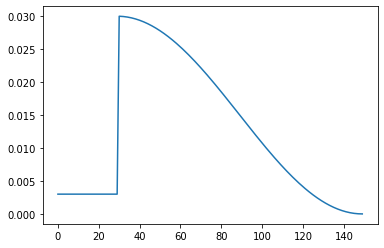

In [295]:
steps = []
for ph in [ph1, ph2]:
    ph.scheds["lr"].restart()
    steps += [ph.scheds["lr"].step() for i in range(ph.scheds["lr"].n_iter)]
plt.plot(steps)

### export

In [20]:
learn.load("mybestmodel");
learn.export("modelexport")
export = torch.load(PATH/"modelexport")
model = export["model"]